In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbrn

fontsize = 13
custom = {"axes.edgecolor": "black","grid.linestyle": "dashed", "grid.color": "gray"}
sbrn.set_context('paper')
sbrn.set_style("whitegrid", rc = custom)

# Open the JSON file for reading
with open('slicejuly11.json', 'r') as file: #TODO add file
    data = json.load(file)

df = pd.json_normalize(data['benchmarks'])
df['repetition_index'] = df['repetition_index'].fillna(0)

In [3]:
# Customize the x-axis ticks to show byte values more clearly
from matplotlib.ticker import FuncFormatter

def byte_formatter(x, pos):
    if x == 0:
        return '0 B'
    elif x < 1024:
        return f'{int(x)} B'
    elif x < 1024**2:
        return f'{int(x / 1024)} KB'
    else:
        return f'{int(x / 1024**2)} MB'

# Customize the y-axis ticks to show time values more clearly
def time_formatter(y, pos):
    if y < 1:
        return f'{y * 1000:.1f} ns'
    elif y < 1000:
        return f'{y:.1f} us'
    elif y < 1000000:
        return f'{y / 1000:.1f} ms'
    else:
        return f'{y / 1000000:.1f} s'

In [4]:
extracted_data = []

# Loop through the benchmarks in the JSON data
for i,benchmark in df.iterrows() :
    
    # Extract the relevant information
    name = benchmark['name']
    real_time = benchmark['real_time']
    bytes = benchmark['bytes']
    
    # Determine the communication type from the name
    if 'deepcopy' in name:
        comm_type = 'KokkosComm_DeepCopy'
    elif 'datatype' in name:
        comm_type = 'KokkosComm_MPIDatatype'
    else:
        continue  # Skip if none
    
    if 'mean' in name:
        extracted_data.append({'comm_type': comm_type, 'real_time': real_time, 'bytes': bytes})
    
edf = pd.DataFrame(extracted_data)

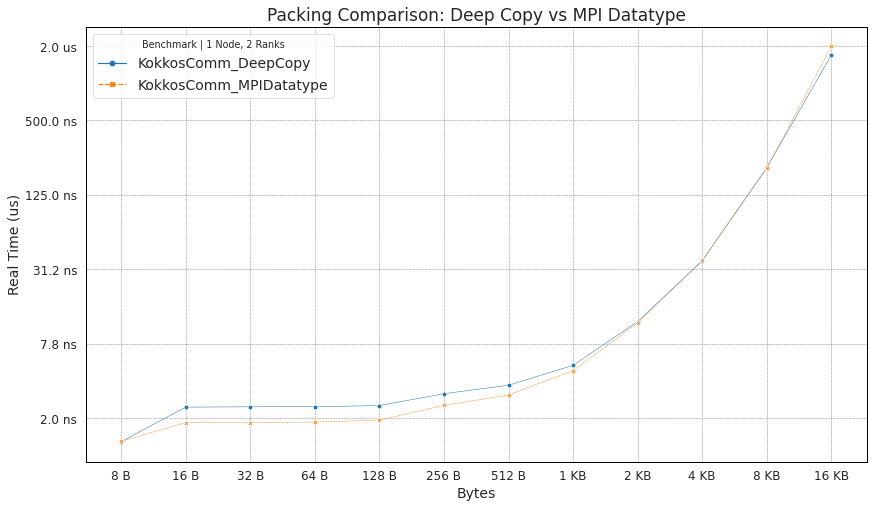

In [5]:
# mpirun -np 2 ./build/perf_tests/perf_test-main 
# --benchmark_repetitions=5 --benchmark_filter=3dslice 
# --benchmark_format=json > "output$(date '+%Y%m%d%H%M%S').json"

# Plot 0: Compare All
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Deep Copy vs MPI Datatype', fontsize=fontsize + 4)

sbrn.lineplot(data=edf, x='bytes', y='real_time', hue='comm_type', 
              style='comm_type', markers=True, ci=None, linewidth=.5)

plt.legend(title='Benchmark | 1 Node, 2 Ranks', fontsize=fontsize+1)
plt.xlabel('Bytes', fontsize=fontsize+1)
plt.ylabel('Real Time (us)', fontsize=fontsize+1)
plt.xticks(fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice1node.png", dpi=300)
plt.show()

In [6]:
# Open the JSON file for reading
with open('slicejuly11_2nodes.json', 'r') as file: #TODO add file
    data = json.load(file)

df = pd.json_normalize(data['benchmarks'])
df['repetition_index'] = df['repetition_index'].fillna(0)

In [7]:
extracted_data = []

# Loop through the benchmarks in the JSON data
for i,benchmark in df.iterrows() :
    
    # Extract the relevant information
    name = benchmark['name']
    real_time = benchmark['real_time']
    bytes = benchmark['bytes']
    
    # Determine the communication type from the name
    if 'deepcopy' in name:
        comm_type = 'KokkosComm_DeepCopy'
    elif 'datatype' in name:
        comm_type = 'KokkosComm_MPIDatatype'
    else:
        continue  # Skip if none
    
    if 'mean' in name:
        extracted_data.append({'comm_type': comm_type, 'real_time': real_time, 'bytes': bytes})
    
edf = pd.DataFrame(extracted_data)

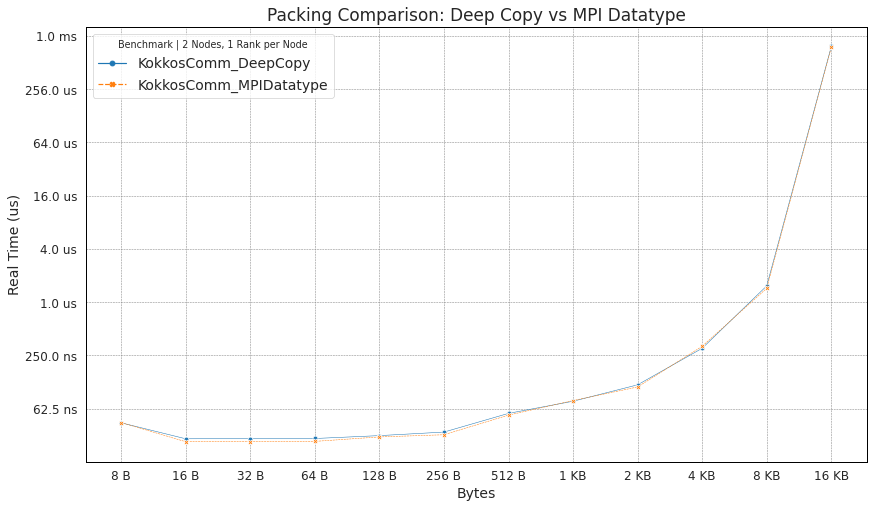

In [8]:
# mpirun -np 2 ./build/perf_tests/perf_test-main 
# --benchmark_repetitions=5 --benchmark_filter=3dslice 
# --benchmark_format=json > "output$(date '+%Y%m%d%H%M%S').json"

# Plot 1: Compare All 2 Nodes
plt.figure(figsize=(14, 8))
plt.title('Packing Comparison: Deep Copy vs MPI Datatype', fontsize=fontsize + 4)

sbrn.lineplot(data=edf, x='bytes', y='real_time', hue='comm_type', 
              style='comm_type', markers=True, ci=None, linewidth=.5)

plt.legend(title='Benchmark | 2 Nodes, 1 Rank per Node', fontsize=fontsize+1)
plt.xlabel('Bytes', fontsize=fontsize+1)
plt.ylabel('Real Time (us)', fontsize=fontsize+1)
plt.xticks(fontsize=fontsize-1)
plt.yticks(fontsize=fontsize-1)

plt.gca().set_xscale("log", base=2)
plt.gca().set_yscale("log", base=2)
plt.gca().xaxis.set_major_formatter(FuncFormatter(byte_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(time_formatter))

# Increase the number of x-axis ticks
from matplotlib.ticker import LogLocator
plt.gca().xaxis.set_major_locator(LogLocator(base=2, numticks=20))

plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.savefig("./PNG/3dslice2nodes.png", dpi=300)
plt.show()